# 1. Information about the submission

## 1.1 Name and number of the assignment 

**Semantic Role Labelling**. Assignment 2

## 1.2 Student name

**Nikolay Kalmykov**

## 1.3 Codalab user ID

**Nick**

# 2. Technical Report

## 2.1 Methodology 

I applied `CRF model` for named-entity recognition using `sklearn-crfsuite` in this dataset.

1) Create datasets with ColumnCorpus

2) Add the pos-tagging to each token

3) Analyze each token with `word features`

4) Create a model and fit on the train data

5) Predict labels for `test and dev datasets`


## 2.2 Discussion of results

The CRF model works quite well for `dev_no_answers` and `test_no_answers` dataset.

Method | F1 Average | F1 Object | F1 Aspect | F1 Predicate | F1 Average partial | F1 Object partial | F1 Aspect partial | F1 Predicate partial
--- | --- | --- | --- |--- | --- | --- | --- |--- |
Baseline | 0.5359 | 0.4736 | 0.2852 | 0.8199 | 0.5527 | 0.4743 | 0.3390 | 0.8416
CRF | 0.6136 | 0.5357 | 0.4342 | 0.8788 | 0.6199 | 0.5364 | 0.4483 | 0.8904

However, F1 score isn't much higher from the baseline. The results may be better if deep learning models are used (any - `embeddings + LSTM, BERT, ELMO ...`). Besides, it's possible to add more features, use multi-task learning, etc.

# 3. Code

## 3.1 Requirements

In [ ]:
!pip install \
transformers==3.0.1 \
seqeval \
tqdm \
flair \
sklearn_crfsuite \
nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U 'scikit-learn<0.24'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')

import sklearn_crfsuite
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report
from flair.datasets import ColumnCorpus
from collections import Counter
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## 3.2 Download the data

In [ ]:
!wget https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/train.tsv
!wget https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/test_no_answers.tsv
!wget https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/dev_no_answers.tsv

--2022-12-14 16:06:10--  https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599430 (585K) [text/plain]
Saving to: ‘train.tsv’

train.tsv           100%[===================>] 585.38K  --.-KB/s    in 0.003s  

2022-12-14 16:06:11 (167 MB/s) - ‘train.tsv’ saved [599430/599430]

--2022-12-14 16:06:11--  https://raw.githubusercontent.com/s-nlp/semantic-role-labelling/main/test_no_answers.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58177 (57K) [text/plai

In [ ]:
!head -n 20 ./train.tsv

also	O
,	O
i	O
have	O
recently	O
discovered	O
advil	B-Object
liquigels	O
work	O
much	O
better	B-Predicate
and	O
faster	B-Predicate
for	O
a	O
headache	B-Aspect
than	O
regular	O
ibuprofen	B-Object
.	O


In [ ]:
data_folder = './'
corpora = ColumnCorpus(data_folder, 
                      {0 : 'text', 1 : 'ner'},
                      train_file='train.tsv',
                      test_file='test_no_answers.tsv',
                      dev_file='dev_no_answers.tsv')
# print(corpora.obtain_statistics())

2022-12-14 16:06:12,210 Reading data from .
2022-12-14 16:06:12,213 Train: train.tsv
2022-12-14 16:06:12,214 Dev: dev_no_answers.tsv
2022-12-14 16:06:12,215 Test: test_no_answers.tsv


In [ ]:
def create_dataset(flair_dataset, preprocess=False):
    dataset = []
    
    for sent in flair_dataset:
        tokens = [w.text for w in sent]
        labels = [w.get_tag('ner').value for w in sent]
        # add pos tagging
        if preprocess:
            dataset.append((list(zip(tokens, [nltk.pos_tag([tok])[0][1] for tok in tokens])), labels))
        else:
            dataset.append((tokens, labels))
    return dataset

In [ ]:
train_dataset = create_dataset(corpora.train, preprocess=True)
dev_dataset = create_dataset(corpora.dev, preprocess=True)
test_dataset = create_dataset(corpora.test, preprocess=True)
dev_dataset_1 = create_dataset(corpora.dev, preprocess=False)
test_dataset_1 = create_dataset(corpora.test, preprocess=False)
train_dataset_1 = create_dataset(corpora.train, preprocess=False)

### Example

In [ ]:
for count, sent in enumerate(corpora.train):
    if count == 0:
        tokens = [w.text for w in sent]
        labels = [w.get_tag('ner').value for w in sent]
        print(sent)
        print('Tokens: ', tokens)
        print('Labels: ', labels)
        print('Tokens with pos tag: ', (list(zip(tokens, [nltk.pos_tag([tok])[0][1] for tok in tokens]))))

Sentence: "also , i have recently discovered advil liquigels work much better and faster for a headache than regular ibuprofen ."   [− Tokens: 20  − Token-Labels: "also , i have recently discovered advil <B-Object> liquigels work much better <B-Predicate> and faster <B-Predicate> for a headache <B-Aspect> than regular ibuprofen <B-Object> ."]
Tokens:  ['also', ',', 'i', 'have', 'recently', 'discovered', 'advil', 'liquigels', 'work', 'much', 'better', 'and', 'faster', 'for', 'a', 'headache', 'than', 'regular', 'ibuprofen', '.']
Labels:  ['O', 'O', 'O', 'O', 'O', 'O', 'B-Object', 'O', 'O', 'O', 'B-Predicate', 'O', 'B-Predicate', 'O', 'O', 'B-Aspect', 'O', 'O', 'B-Object', 'O']
Tokens with pos tag:  [('also', 'RB'), (',', ','), ('i', 'NN'), ('have', 'VB'), ('recently', 'RB'), ('discovered', 'VBN'), ('advil', 'NN'), ('liquigels', 'NNS'), ('work', 'NN'), ('much', 'JJ'), ('better', 'RBR'), ('and', 'CC'), ('faster', 'NN'), ('for', 'IN'), ('a', 'DT'), ('headache', 'NN'), ('than', 'IN'), ('regu

## 3.3 Statistics

In [ ]:
sentences = [' '.join(sent[0]) for sent in train_dataset_1]
labels =  [sent[1] for sent in train_dataset_1]
df = pd.DataFrame({'sentences': sentences, 'labels': labels})
df

,sentences,labels
0,"also , i have recently discovered advil liquig...","[O, O, O, O, O, O, B-Object, O, O, O, B-Predic..."
1,i have always heard that motrin is better than...,"[O, O, O, O, O, B-Object, O, B-Predicate, O, B..."
2,when i was a figure skater i injuried my ankle...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"in a way , halloween is even better than thank...","[O, O, O, O, B-Object, O, O, B-Predicate, O, B..."
4,i think halloween is actually safer than chris...,"[O, O, B-Object, O, O, B-Predicate, O, O, O, B..."
...,...,...
2329,isn ' t plastic safer than wood .,"[O, O, O, B-Object, B-Predicate, O, B-Object, O]"
2330,"and plastic pallets are safer than wood , beca...","[O, B-Object, O, O, B-Predicate, O, B-Object, ..."
2331,plastic laminate flooring is one of the most a...,"[B-Object, O, B-Aspect, O, O, O, O, O, O, O, O..."
2332,plastic has long been considered superior to w...,"[B-Object, O, O, O, O, B-Predicate, O, B-Objec..."


In [ ]:
def visualize_distr(data: Counter):
    data = sorted(data.items())
    labels = list([elem[0] for elem in data])
    p = plt.bar(x=labels, height=[elem[1] for elem in data])
    
    sum_values = sum([elem[1] for elem in data])
    for rect1 in p:
        height = rect1.get_height()
        plt.annotate(
            f'{height}\n{height*100/sum_values:.1f}%', 
            (rect1.get_x() + rect1.get_width()/2, height+.05),
            ha="center", va="bottom", fontsize=12
        )
    plt.show()


def show_statistic(df: pd.DataFrame):
    
    NE_distribution = Counter()

    count_tokens = 0
    count_named_entities = 0
    for labels in df['labels']:
        count_tokens += len(labels)
        NE_labels = [label[2:] for label in labels if label != 'O']
        count_named_entities += len(NE_labels)
        NE_distribution.update(NE_labels)

    
    print(f'Count sentences: {df.shape[0]}')
    print(f'Count tokens: {count_tokens}')
    print(f'Count unnamed tokens: {count_tokens - count_named_entities} | {(count_tokens - count_named_entities) * 100 / count_tokens:.1f}%')
    print(f'Count named tokens (NE): {count_named_entities} | {count_named_entities * 100 / count_tokens:.1f}%')
    print('\nNamed tokens distribution')
    visualize_distr(NE_distribution)

Count sentences: 2334
Count tokens: 61074
Count unnamed tokens: 48512 | 79.4%
Count named tokens (NE): 12562 | 20.6%

Named tokens distribution


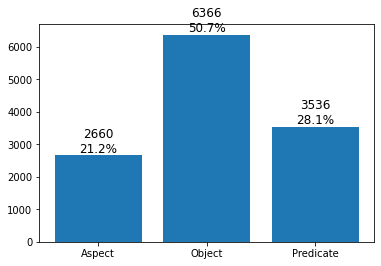

In [ ]:
show_statistic(df)

## 3.4 Preprocessing

In [ ]:
def word_features(sentence, i):
    # Get the current word and POS
    word = sentence[i][0]
    pos = sentence[i][1]

    features = { "bias": 1.0,
                 "word.lower()": word.lower(),
                 "word[-3:]": word[-3:],
                 "word[-2:]": word[-2:],
                 "word.isupper()": word.isupper(),
                 "word.istitle()": word.istitle(),
                 "word.isdigit()": word.isdigit(),
                 "pos": pos,
                 "pos[:2]": pos[:2], # Generalized POS
               }
   
    # If this is not the first word in the sentence
    if i > 0:
        # Get the sentence's previous word and POS
        prev_word = sentence[i-1][0] if len(sentence) > 1 else ''
        prev_pos = sentence[i-1][1] if len(sentence) > 1 else ''
        # Add characteristics of the sentence's previous word and POS to the feature dictionary
        features.update({ "-1:word.lower()": prev_word.lower(),
                          "-1:word.istitle()": prev_word.istitle(),
                          "-1:word.isupper()": prev_word.isupper(),
                          "-1:pos": prev_pos,
                          "-1:pos[:2]": prev_pos[:2],
                        })
        
    # Otherwise, add 'BOS' (beginning of sentence) to the feature dictionary
    else:
        features["BOS"] = True

    # If this is not the last word in the sentence...
    if i < len(sentence)-1:
        # Get the sentence's next word and POS
        next_word = sentence[i+1][0] if len(sentence) > 1 else ''
        next_pos = sentence[i+1][1] if len(sentence) > 1 else ''
        # Add characteristics of the sentence's previous next and POS to the feature dictionary
        features.update({ "+1:word.lower()": next_word.lower(),
                          "+1:word.istitle()": next_word.istitle(),
                          "+1:word.isupper()": next_word.isupper(),
                          "+1:pos": next_pos,
                          "+1:pos[:2]": next_pos[:2],
                        })
        
    # Otherwise, add 'EOS' (end of sentence) to the feature dictionary
    else:
        features["EOS"] = True
    
    return features


def sentence_features(sentence):
    return [word_features(sentence, i) for i in range(len(sentence))]

## 3.5 Creating a model

In [ ]:
X = [sentence_features(sentence[0]) for sentence in train_dataset] # list of features for each token of sentences
y = [sentence[1] for sentence in train_dataset] # list of labels for each token

In [ ]:
X[0]

[{'bias': 1.0,
  'word.lower()': 'also',
  'word[-3:]': 'lso',
  'word[-2:]': 'so',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'pos': 'RB',
  'pos[:2]': 'RB',
  'BOS': True,
  '+1:word.lower()': ',',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:pos': ',',
  '+1:pos[:2]': ','},
 {'bias': 1.0,
  'word.lower()': ',',
  'word[-3:]': ',',
  'word[-2:]': ',',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'pos': ',',
  'pos[:2]': ',',
  '-1:word.lower()': 'also',
  '-1:word.istitle()': False,
  '-1:word.isupper()': False,
  '-1:pos': 'RB',
  '-1:pos[:2]': 'RB',
  '+1:word.lower()': 'i',
  '+1:word.istitle()': False,
  '+1:word.isupper()': False,
  '+1:pos': 'NN',
  '+1:pos[:2]': 'NN'},
 {'bias': 1.0,
  'word.lower()': 'i',
  'word[-3:]': 'i',
  'word[-2:]': 'i',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'pos': 'NN',
  'pos[:2]': 'NN',
  '-1:word.lower()': 

In [ ]:
y[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Object',
 'O',
 'O',
 'O',
 'B-Predicate',
 'O',
 'B-Predicate',
 'O',
 'O',
 'B-Aspect',
 'O',
 'O',
 'B-Object',
 'O']

In [ ]:
model = sklearn_crfsuite.CRF()
model.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(keep_tempfiles=None)

In [ ]:
X_train = [sentence_features(sentence[0]) for sentence in train_dataset]
preds = model.predict(X_train)
f1_score = f1_score([e[1] for e in train_dataset], preds)

In [ ]:
print(f'F1 score: {f1_score}')

F1 score: 0.8733081668354664


In [ ]:
print(classification_report([e[1] for e in train_dataset], preds))

              precision    recall  f1-score   support

      Aspect       0.79      0.43      0.56      2069
      Object       0.94      0.94      0.94      6174
   Predicate       0.91      0.91      0.91      3109

   micro avg       0.91      0.84      0.87     11352
   macro avg       0.88      0.76      0.80     11352
weighted avg       0.90      0.84      0.86     11352



## Preds for Dev Dataset

In [ ]:
pred_data = dev_dataset[0]
X_pred = [sentence_features(sentence[0]) for sentence in [pred_data]]
preds = model.predict(X_pred)

list(zip([e[0] for e in pred_data[0]], preds[0]))

[('meanwhile', 'O'),
 (',', 'O'),
 ('though', 'O'),
 ('windows', 'O'),
 ('8', 'O'),
 ('is', 'O'),
 ('significantly', 'O'),
 ('at', 'O'),
 ('greater', 'O'),
 ('risk', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 ('.', 'O'),
 ('73', 'O'),
 ('percent', 'O'),
 (')', 'O'),
 ('compared', 'O'),
 ('to', 'O'),
 ('windows', 'O'),
 ('8', 'O'),
 ('.', 'O'),
 ('1', 'O'),
 (',', 'O'),
 ('according', 'O'),
 ('to', 'O'),
 ('redmond', 'O'),
 ("'", 'O'),
 ('s', 'O'),
 ('report', 'O'),
 (',', 'O'),
 ('it', 'O'),
 ("'", 'O'),
 ('s', 'O'),
 ('still', 'O'),
 ('significantly', 'O'),
 ('safer', 'B-Predicate'),
 ('than', 'O'),
 ('windows', 'B-Object'),
 ('7', 'O'),
 (',', 'O'),
 ('windows', 'O'),
 ('xp', 'O'),
 (',', 'O'),
 ('or', 'O'),
 ('windows', 'O'),
 ('vista', 'O'),
 ('.', 'O')]

In [ ]:
X_test = [sentence_features(sentence[0]) for sentence in dev_dataset]
preds = model.predict(X_test)

In [ ]:
sentences = [sent[0] for sent in dev_dataset_1]
with open("out_dev.tsv", "w") as w:
    for words, labels in zip(sentences, preds):
      for i, y in zip(words, labels):

          # print(f"{i}\t{y}\n")
          w.write(f"{i}\t{y}\n")

      w.write("\n")

In [ ]:
!zip out_dev.zip out_dev.tsv

  adding: out_dev.tsv (deflated 73%)


## Preds for Test Dataset

In [ ]:
X_test = [sentence_features(sentence[0]) for sentence in test_dataset]
preds = model.predict(X_test)

In [ ]:
sentences = [sent[0] for sent in test_dataset_1]
with open("out_test.tsv", "w") as w:
    for words, labels in zip(sentences, preds):
      for i, y in zip(words, labels):

          w.write(f"{i}\t{y}\n")

      w.write("\n")

In [ ]:
!zip out_test.zip out_test.tsv

  adding: out_test.tsv (deflated 74%)
